This is an experiment section validating the model generalization on a dataset that is more representative to the real-life situation.  

The data set is from: https://www.kaggle.com/datasets/maharshipandya/email-spam-dataset-extended.
It is stored under the archive directory.

## Summary

<mark>Best performance is:  the combination of content + from + to + date with Multinomial Naive Bayes  

accuracy: 0.9762443438914027 precision: 0.9347408829174664, recall: 0.9838383838383838, f1: 0.9586614173228347</mark>  


In this experiment, we use weighted class TF-IDF for vectorization. However, this would introduce in bias due to:  
1. When dataset is imbalanced, TF-IDF will end up with the majority of words chosen being from the majority class;  and this bias got strengthened by class weighted.
2. we use the terms extracted from one class samples as stop words during extraction for another class; the order to process classes can introduce in bias.  

<mark>What can be better:</mark>  
1. Vectorization ngram range hasn't been tested
2. We could possibly inverse the proportion of classes when doing weighted class TF-IDF. This needs further testing.
3. The information extracted from email headers, especially Date/Cc Account Amount, does not bring in sufficient improvements. Perhaps we should try other ways to pre-process them.  


<mark>Bayes Related</mark>:
This experiment uses all extracted information within one Naive Bayes classifier. Perhaps it would be better if we can separate the training and predicting to: 1. Content Based Filter; 2. Header Based Filter.


In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, ComplementNB 

import email
import string
from bs4 import BeautifulSoup
from collections import Counter

RANDOM_SEED = 2020

## 1. Read Data

In [2]:
spam_data_path = "./archive/spam_zipped/main_spam/"
ham_data_path = "./archive/ham_zipped/main_ham/"

spam_files = [name for name in sorted(os.listdir(spam_data_path))]
ham_files = [name for name in sorted(os.listdir(ham_data_path))]

### 1.1 Check if the data is representative

In [3]:
print("spam percentage: {}".format(len(spam_files)/(len(spam_files)+len(ham_files))))
print("ham percentage: {}".format(len(ham_files)/(len(spam_files)+len(ham_files))))

spam percentage: 0.2564980211787357
ham percentage: 0.7435019788212643


Around 25.65% of samples are labeled as spam emails, and the rest as ham emails.  
It is fair to say that this dataset is representative as in real life, ham emails would usually be the majority class.

### 1.2 Create email parsers

ref: https://www.kaggle.com/code/maharshipandya/email-spam-classification-98/notebook  
ref: https://www.section.io/engineering-education/email-parser-python/

In [4]:
def load_email_to_parser(email_file, is_spam=True):
    data_path = spam_data_path if is_spam else ham_data_path
    with open(os.path.join(data_path, email_file), "rb") as file:
        return email.parser.BytesParser().parse(file)

In [5]:
ham_parsers = [load_email_to_parser(email_file, False) for email_file in ham_files]
spam_parsers = [load_email_to_parser(email_file, True) for email_file in spam_files]

### 1.3 Email Headers

In [6]:
for header, value in ham_parsers[3].items():
    print("{}:{}".format(header, value))

Return-Path:<exmh-workers-admin@spamassassin.taint.org>
Delivered-To:yyyy@localhost.netnoteinc.com
Received:from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id DE7E443C32
	for <jm@localhost>; Wed, 21 Aug 2002 11:18:34 -0400 (EDT)
Received:from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Wed, 21 Aug 2002 16:18:34 +0100 (IST)
Received:from listman.spamassassin.taint.org (listman.spamassassin.taint.org [66.187.233.211]) by
    dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id g7LFFwZ30827 for
    <jm-exmh@jmason.org>; Wed, 21 Aug 2002 16:16:07 +0100
Received:from listman.spamassassin.taint.org (localhost.localdomain [127.0.0.1]) by
    listman.redhat.com (Postfix) with ESMTP id 78A9B405D2; Wed, 21 Aug 2002
    11:16:02 -0400 (EDT)
Delivered-To:exmh-workers@listman.spamassassin.taint.org
Received:from int-mx1.corp.spamassassin.taint.org (int-mx1.corp.spamassassin.taint.org
    [172.16.52.254]) by li

Information we need to extract for potential future use is:
1. From 
2. To 
3. CC account amount
4. Date, e.g. Wed
5. time, e.g. 19:30:01 (PS. droped; too many missing values)  
6. Subject, e.g. Never Repay Cash Grants, 500 - 50,000, Secret Revealed!

In [7]:
# ham email: 0, spam email: 1

all_data_frame = pd.DataFrame(columns=["class", "From", "To", "Cc", "Date"])

header_keys = ["From", "To", "Cc", "Date"]


def read_header_to_df(email, is_spam, all_data_frame):
    row_info = {"class":is_spam, "From":"Unknown", "To":"Unknown", "Cc":0, "Date":np.nan}
    for key in header_keys:
        if key in email.keys():
            if key=="From" or "To":
                row_info[key] = str(email[key]) if email[key] else "Unknown"
            if key=="Cc":
                row_info[key] = len(email[key].split(","))
            if key=="Date":
                splits = email[key].split(" ")
                row_info["Date"] = splits[0][:-1]
    all_data_frame.loc[len(all_data_frame)] = row_info

for email in ham_parsers:
    read_header_to_df(email, 0, all_data_frame)
for email in spam_parsers:
    read_header_to_df(email, 1, all_data_frame)

### 1.3 Email Body

The two functions below are from: https://www.kaggle.com/code/maharshipandya/email-spam-classification-98/notebook  

In [8]:
def html_to_text(email):
    try:
        soup = BeautifulSoup(email.get_payload(), "html.parser")
        plain = soup.text.replace("=\n", "")
        plain = re.sub(r"\s+", " ", plain)
        return plain.strip()
    except:
        return "Nothing"

def email_to_text(email):
    text_content = ""
    for part in email.walk():
        part_content_type = part.get_content_type()
        if part_content_type not in ['text/plain', 'text/html']:
            continue
        if part_content_type == 'text/plain':
            text_content += part.get_payload()
        else:
            text_content += html_to_text(part)
    return text_content
    

### 1.4 Clean Up Email Body Texts and Construct Data

ref: https://machinelearningmastery.com/clean-text-machine-learning-python/#:~:text=Clean%20text%20often%20means%20a,new%20lines%2C%20tabs%20and%20more.  

In this section, we will go through each email parser and extract its content out to texts.  
Pre-processing clean up will run on these texts, such as removing punctuation, converting letters to lower case.


In [11]:
all_contents = []

for email in ham_parsers+spam_parsers:
    content = email_to_text(email)
    content = content.lower()
    for punc in string.punctuation:
        content = content.replace(punc, "")
    for term in ["\n", "\t", "\s"]:
        content = content.replace(punc, "")
    all_contents.append(content)

all_data_frame["content"] = all_contents
display(all_data_frame)


,class,From,To,Cc,Date,content
0,0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030314468.7c7c85@D...,1,Wed,date tue 20 aug 2002 172747 0500\n ...
1,0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,1,Thu,date wed 21 aug 2002 105446 0500\n ...
2,0,The Motley Fool <Fool@motleyfool.com>,mkettler@home.com,0,Wed,\n the motley fool \n p...
3,0,Chris Garrigues <cwg-exmh@DeepEddy.Com>,Valdis.Kletnieks@vt.edu,1,Wed,from valdiskletnieksvtedu\n date wed 21 aug...
4,0,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",0,Thu,martin a posted\ntassos papadopoulos the greek...
...,...,...,...,...,...,...
9344,1,biz2biz2446@Flashmail.com,"<ejennifer3@uswest.net>, <as99@hotmail.com>, <...",9,Tue,there is no stumbling on to it \n\nthe greates...
9345,1,"""IQ - CNA"" <cna@insiq.us>",<zzzz@jmason.org>,0,Mon,what does it mean to be made in the usa\n cna...
9346,1,Answer.Us@davicom.co.kr,undisclosed-recipients:;,0,0,nothing
9347,1,beautyinfufuxxxmeb13mxy@aol.com,<Mike@dogma.slashnull.org>,0,Mon,nothing


## 2. Data Cleanup and Analyze

### 2.1 Missing Data

In [ ]:
msno.matrix(all_data_frame)

In [12]:
all_data_frame.dropna(inplace=True)

### 2.2 Analyze Features and Validity

In [13]:
# Date Feature
valid_date = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
date = all_data_frame["Date"].values

invalid_index = [True if date_v in valid_date else False for date_v in date]

all_data_frame = all_data_frame[pd.Series(invalid_index).values]

# discrete date information
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(all_data_frame["Date"])

copy_df = all_data_frame.drop(columns="Date")
copy_df["Date"] = labels
all_data_frame = copy_df

In [14]:
all_data_frame["Cc"] = pd.qcut(all_data_frame["Cc"], 5, precision=0, labels=False, duplicates='drop')

In [15]:
display(all_data_frame)

,class,From,To,Cc,content,Date
0,0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030314468.7c7c85@D...,0,date tue 20 aug 2002 172747 0500\n ...,6
1,0,Robert Elz <kre@munnari.OZ.AU>,Chris Garrigues <cwg-dated-1030377287.06fa6d@D...,0,date wed 21 aug 2002 105446 0500\n ...,4
2,0,The Motley Fool <Fool@motleyfool.com>,mkettler@home.com,0,\n the motley fool \n p...,6
3,0,Chris Garrigues <cwg-exmh@DeepEddy.Com>,Valdis.Kletnieks@vt.edu,0,from valdiskletnieksvtedu\n date wed 21 aug...,6
4,0,Steve Burt <Steve_Burt@cursor-system.com>,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoo...",0,martin a posted\ntassos papadopoulos the greek...,4
...,...,...,...,...,...,...
9343,1,2002biz2biz2513@Flashmail.com,"<ejennifer3@uswest.net>, <as99@hotmail.com>, <...",1,there is no stumbling on to it \n\nthe greates...,5
9344,1,biz2biz2446@Flashmail.com,"<ejennifer3@uswest.net>, <as99@hotmail.com>, <...",1,there is no stumbling on to it \n\nthe greates...,5
9345,1,"""IQ - CNA"" <cna@insiq.us>",<zzzz@jmason.org>,0,what does it mean to be made in the usa\n cna...,1
9347,1,beautyinfufuxxxmeb13mxy@aol.com,<Mike@dogma.slashnull.org>,0,nothing,1


### 2.3 Split Train Set and Test Set

In [16]:
# shuffling data
all_data_frame = all_data_frame.sample(frac=1).reset_index(drop=True)
display(all_data_frame)

all_y = all_data_frame["class"].values  # all label values
all_x = all_data_frame.drop(columns=["class"]).values # all features' values

# split data frame to train set and test set use sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(all_x, all_y, test_size=0.2, random_state=RANDOM_SEED)

# check the sets are splitted correctly
all_y.shape, all_x.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

,class,From,To,Cc,content,Date
0,1,"""BILSAG"" <bilsag@yahoo.com>",<sitescooper-talk@example.sourceforge.net>,0,nothing,3
1,1,"""Mandy Barton"" <svzsx@wanadoo.fr>",<body@katomic.com>,0,nothing,5
2,0,"""Brian O'Donoghue"" <Brian.ODonoghue@kbs.ie>","""'ilug@linux.ie'"" <ilug@linux.ie>",0,\n\n ok iknow this is blatantly ot but im beg...,6
3,1,Membership Adult Club <ib@newafrica.com>,zzzz@example.com,0,\n ...,3
4,0,bitbitch@magnesium.net,Elias <fork@spamassassin.taint.org>,0,hello elias\n\ntuesday october 1 2002 95402 pm...,5
...,...,...,...,...,...,...
8832,0,kevin lyda <kevin+dated+1028225744.d700ac@ie.s...,irish linux users group <ilug@linux.ie>,0,saw this on mutt users might be a handy trick...,2
8833,0,zawodny <rssfeeds@spamassassin.taint.org>,yyyy@spamassassin.taint.org,0,url httpjeremyzawodnycomblogarchives000225html...,5
8834,1,"""europe info"" <infoeurope@lycos.com>",infoeurope@lycos.com,0,fromzimmy mabo\ntel0031623787971 ...,6
8835,0,ZDNet Shopper <Online#3.19908.0a-BsA8gPyVcnFqA...,qqqqqqqqqq-zdnet@spamassassin.taint.org,0,nothing,0


((8837,), (8837, 5), (7069, 5), (1768, 5), (7069,), (1768,))

## 3. Vectorization

ref: https://www.deepwizai.com/projects/how-to-correctly-use-tf-idf-with-imbalanced-data  

In our experiment, a weighted class TF-IDF is used for vectorization.  
The idea is to run TF-IDF on samples for each class separately, then convert all extracted terms into one vocabulary to fit the model.

In [17]:
def get_feature_amount_for_class(classes, total_amount):
    class_feature_amount = {}
    allocate_amount = 0
    
    class_counter = dict(Counter(classes))
    class_types = list(class_counter.keys())
    
    for cls in class_types[:-1]:
        class_feature_amount[cls] = int(total_amount*(class_counter[cls]/len(classes)))
        allocate_amount += class_feature_amount[cls]
    class_feature_amount[class_types[-1]] = total_amount - allocate_amount
    return class_feature_amount

In [18]:
def vocabulary_with_Tfidf(x_train_column, y_train, ngram_range=(1,3), max_features: int = 300, min_df: float = 0.01):
    
    overall_vocabulary = {}
    
    class_feature_amount = get_feature_amount_for_class(list(y_train), max_features)
    
    # get vectorization for each class with extracted vocabulary
    # here is a binary class so it's easier
    used_vocabulary = []
    for cls in class_feature_amount.keys():
        vectorizer = TfidfVectorizer(
            min_df=min_df, max_features=class_feature_amount[cls], ngram_range=ngram_range, stop_words=used_vocabulary
        )
        # find all texture contents for this class type
        indices = [i for i in range(0, len(list(y_train))) if y_train[i]==cls]
        contents = [x_train_column[idx] for idx in indices]
        
        # build tf-idf model
        model = vectorizer.fit(contents)
        used_vocabulary += list(model.vocabulary_.keys())
        
    for i, word in enumerate(used_vocabulary):
        overall_vocabulary[word] = i
    
    return overall_vocabulary
          

In [19]:
def draw_word_cloud(label, feature_train, max_words=200):
    plt.rcParams['font.sans-serif']='SimHei'
    freq_data_frame = pd.DataFrame(feature_train, columns=label)
    feature_mean_freq_dict = dict(freq_data_frame.mean())
    word_cloud = WordCloud(background_color="white",width=1000,height=1000, 
                           max_words=max_words,relative_scaling=0.5,normalize_plurals=False,
                          font_path='simhei.ttf', prefer_horizontal=1).generate_from_frequencies(feature_mean_freq_dict)
    plt.imshow(word_cloud)

### 3.1 Vectorization on "content" feature

In [ ]:
ngram_range = (1,3)
vocabulary = vocabulary_with_Tfidf(x_train[:, 3], y_train, ngram_range, 3000)

cvec_tfidf = TfidfVectorizer(analyzer="word", min_df = 0.01, max_df = 1, ngram_range=ngram_range, vocabulary=vocabulary)

content_feature_name = cvec_tfidf.get_feature_names_out()
content_features_train = cvec_tfidf.fit_transform(x_train[:, 3]).toarray()
content_features_test = cvec_tfidf.fit_transform(x_test[:, 3]).toarray()

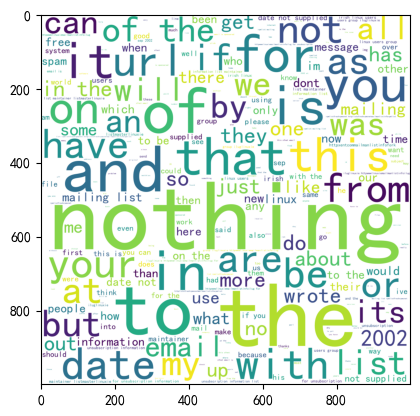

In [21]:
draw_word_cloud(content_feature_name, content_features_train, 300)

### 3.2 Vectorization on  "From" Feature

In [22]:
ngram_range = (1,3)
vocabulary = vocabulary_with_Tfidf(x_train[:, 0], y_train, ngram_range, 300)

cvec_tfidf = TfidfVectorizer(analyzer="word", min_df = 0.01, max_df = 1, ngram_range=ngram_range, vocabulary=vocabulary)

from_feature_name = cvec_tfidf.get_feature_names_out()
from_features_train = cvec_tfidf.fit_transform(x_train[:, 0]).toarray()
from_features_test = cvec_tfidf.fit_transform(x_test[:, 0]).toarray()

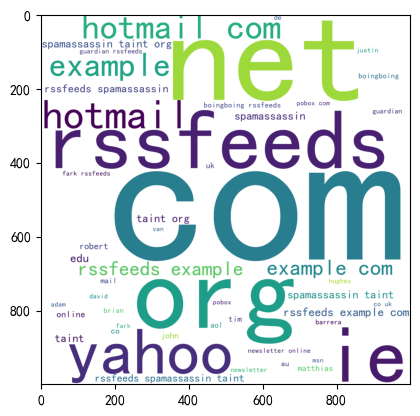

In [23]:
draw_word_cloud(from_feature_name, from_features_train, 50)

### 3.3 Vectorization on  "To" Feature

In [24]:
ngram_range = (1,3)
vocabulary = vocabulary_with_Tfidf(x_train[:, 1], y_train, ngram_range, 300)

cvec_tfidf = TfidfVectorizer(analyzer="word", min_df = 0.01, max_df = 1, ngram_range=ngram_range, vocabulary=vocabulary)

to_feature_name = cvec_tfidf.get_feature_names_out()
to_features_train = cvec_tfidf.fit_transform(x_train[:, 1]).toarray()
to_features_test = cvec_tfidf.fit_transform(x_test[:, 1]).toarray()

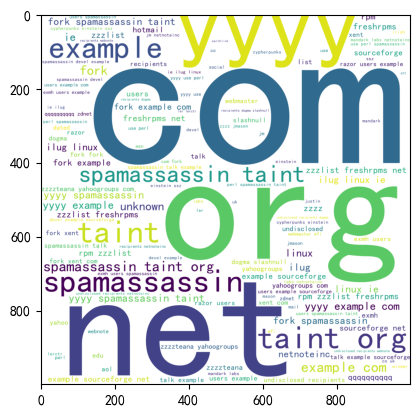

In [25]:
draw_word_cloud(to_feature_name, to_features_train, 200)

### 3.4 Concatenate Final Train Set and Test Set

In [30]:
def get_model_features(x_train_column, x_test_column, y_train, ngram_range=(1,3), max_features=300):
    vocabulary = vocabulary_with_Tfidf(x_train_column, y_train, ngram_range, max_features)

    cvec_tfidf = TfidfVectorizer(analyzer="word", min_df = 0.01, max_df = 1, ngram_range=ngram_range, vocabulary=vocabulary)

    feature_name = cvec_tfidf.get_feature_names_out()
    features_train = cvec_tfidf.fit_transform(x_train_column).toarray()
    features_test = cvec_tfidf.fit_transform(x_test_column).toarray()
    
    return feature_name, features_train, features_test

## 4. Naive Bayes

In [34]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

### 4.1 Use Header Only

In [ ]:
multinomial_nb =  MultinomialNB()
complement_nb = ComplementNB()
classifiers = [multinomial_nb, complement_nb]

max_features = [50, 100, 200, 300, 500, 1000]

cc_train = x_train[:,2]
date_train = x_train[:,4]
cc_test = x_test[:,2]
date_test = x_test[:,4]


# run tests

for classifier in classifiers:
        for max_feature in max_features:
            print("classifier: {}, max_feature: {}".format(classifier, max_feature))
            mean_cross_val = {}
            
            # get header info vectorized
            to_feature_name, to_features_train, to_features_test = get_model_features(
                x_train[:, 1], x_test[:, 1], y_train, ngram_range=(1,3), max_features=max_feature
            )
            from_feature_name, from_features_train, from_features_test = get_model_features(
                x_train[:, 0], x_test[:, 0], y_train, ngram_range=(1,3), max_features=max_feature
            )
            
            # Concatenate Final Train Set and Test Set
            new_train_x = np.concatenate(
                (from_features_train, to_features_train, cc_train[:, np.newaxis], date_train[:, np.newaxis]),axis=1
            )
            new_test_x = np.concatenate(
                (from_features_test, to_features_test, cc_test[:, np.newaxis], date_test[:, np.newaxis]),axis=1
            )
            
            # cross validation
            results = cross_validate(classifier, new_train_x, y_train, cv=5, scoring=scoring)
            #get mean
            for key in results.keys():
                mean_cross_val[key] = np.mean(results[key])
            print("cross validate: \n {} \n \n".format(mean_cross_val))
                

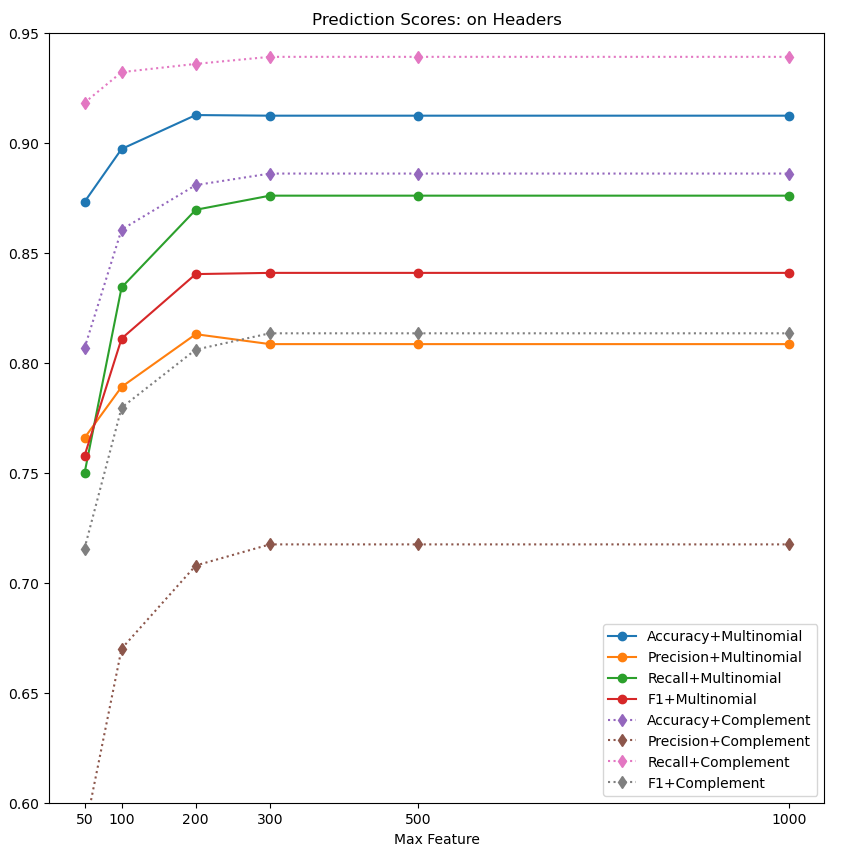  
We will choose Multinomial Naive Bayes with 200 features from headers, and Complementary Naive Bayes with 300 features from headers, for further testing.

In general, Multinomial Naive Bayes performs better than Complementary Naive Bayes.

### 4.2 Multinomial Naive Bayes with 200 features from headers

In [ ]:
multinomial_nb =  MultinomialNB()

# get header info vectorized
to_feature_name, to_features_train, to_features_test = get_model_features(
    x_train[:, 1], x_test[:, 1], y_train, ngram_range=(1,3), max_features=200
)
from_feature_name, from_features_train, from_features_test = get_model_features(
    x_train[:, 0], x_test[:, 0], y_train, ngram_range=(1,3), max_features=200
)

cc_train = x_train[:,2]
date_train = x_train[:,4]
cc_test = x_test[:,2]
date_test = x_test[:,4]

max_features = [500, 1000, 1500, 2000, 3500, 4000, 4500, 5000, 5500]

for max_feature in max_features:
    print("max_feature: {}".format(max_feature))
    mean_cross_val = {}
    
    content_feature_name, content_features_train, content_features_test = get_model_features(
                x_train[:, 3], x_test[:, 3], y_train, ngram_range=(1,3), max_features=max_feature
            )
    
    new_train_x = np.concatenate(
        (from_features_train, to_features_train, content_features_train, cc_train[:, np.newaxis], date_train[:, np.newaxis]),axis=1
    )
    new_test_x = np.concatenate(
        (from_features_test, to_features_test, content_features_test, cc_test[:, np.newaxis], date_test[:, np.newaxis]),axis=1
    )
    
    # cross validation
    results = cross_validate(multinomial_nb, new_train_x, y_train, cv=5, scoring=scoring)
    #get mean
    for key in results.keys():
        mean_cross_val[key] = np.mean(results[key])
    print("cross validate: \n {} \n \n".format(mean_cross_val))
    

Best performance:   
max_feature: 4500
cross validate: 
 {'fit_time': 0.6321043491363525, 'score_time': 0.1595999240875244, 'test_accuracy': 0.9708591969297021, 'test_precision': 0.9196337549405381, 'test_recall': 0.9719780219780219, 'test_f1_score': 0.9449986512131359} 

### 4.3 Complementary Naive Bayes with 300 features from headers

In [ ]:
complement_nb = ComplementNB()

# get header info vectorized
to_feature_name, to_features_train, to_features_test = get_model_features(
    x_train[:, 1], x_test[:, 1], y_train, ngram_range=(1,3), max_features=300
)
from_feature_name, from_features_train, from_features_test = get_model_features(
    x_train[:, 0], x_test[:, 0], y_train, ngram_range=(1,3), max_features=300
)

cc_train = x_train[:,2]
date_train = x_train[:,4]
cc_test = x_test[:,2]
date_test = x_test[:,4]

max_features = [500, 1000, 1500, 2000, 3500, 4000, 4500, 5000, 5500]

for max_feature in max_features:
    print("max_feature: {}".format(max_feature))
    mean_cross_val = {}
    
    content_feature_name, content_features_train, content_features_test = get_model_features(
                x_train[:, 3], x_test[:, 3], y_train, ngram_range=(1,3), max_features=max_feature
            )
    
    new_train_x = np.concatenate(
        (from_features_train, to_features_train, content_features_train, cc_train[:, np.newaxis], date_train[:, np.newaxis]),axis=1
    )
    new_test_x = np.concatenate(
        (from_features_test, to_features_test, content_features_test, cc_test[:, np.newaxis], date_test[:, np.newaxis]),axis=1
    )
    
    # cross validation
    results = cross_validate(complement_nb, new_train_x, y_train, cv=5, scoring=scoring)
    #get mean
    for key in results.keys():
        mean_cross_val[key] = np.mean(results[key])
    print("cross validate: \n {} \n \n".format(mean_cross_val))
    

Best performance:  
max_feature: 1500
cross validate: 
 {'fit_time': 0.2967996597290039, 'score_time': 0.07503066062927247, 'test_accuracy': 0.9644930735111729, 'test_precision': 0.889716238959252, 'test_recall': 0.9840659340659341, 'test_f1_score': 0.9345044443288977} 

### 4.4 If Exclude Any Feature Improve Behavior

In [ ]:
multinomial_nb =  MultinomialNB()

# get header info vectorized
to_feature_name, to_features_train, to_features_test = get_model_features(
    x_train[:, 1], x_test[:, 1], y_train, ngram_range=(1,3), max_features=200
)
from_feature_name, from_features_train, from_features_test = get_model_features(
    x_train[:, 0], x_test[:, 0], y_train, ngram_range=(1,3), max_features=200
)

cc_train = x_train[:,2]
date_train = x_train[:,4]
cc_test = x_test[:,2]
date_test = x_test[:,4]

max_features = [1500, 2000, 3500, 4000, 4500, 5000, 5500]

for max_feature in max_features:
    print("max_feature: {}".format(max_feature))
    mean_cross_val = {}
    
    content_feature_name, content_features_train, content_features_test = get_model_features(
                x_train[:, 3], x_test[:, 3], y_train, ngram_range=(1,3), max_features=max_feature
            )
    
    new_train_x = np.concatenate(
        (from_features_train, to_features_train, content_features_train, date_train[:, np.newaxis]),axis=1
    )
    new_test_x = np.concatenate(
        (from_features_test, to_features_test, content_features_test, date_test[:, np.newaxis]),axis=1
    )
    # cross validation
    results = cross_validate(multinomial_nb, new_train_x, y_train, cv=5, scoring=scoring)
    #get mean
    for key in results.keys():
        mean_cross_val[key] = np.mean(results[key])
    print("cross validate: \n {} \n \n".format(mean_cross_val))
    

Cc feature: wether to discrete, it has limited information as the value is mainly 0 and 1;  
If we want to use this, perhaps we should not use Bayes to interpret.

1. With only the content features, best behavior is:  
    max_feature: 3500
    cross validate: 
     {'fit_time': 0.09335050582885743, 'score_time': 0.014164972305297851, 'test_accuracy': 0.947235560680727,  'test_precision': 0.8702576852046662, 'test_recall': 0.9346153846153846, 'test_f1_score': 0.9012557423476132}   
     
     
2. With content feature and "To" feature:  
    max_feature: 4500
    cross validate: 
     {'fit_time': 0.11288218498229981, 'score_time': 0.015956974029541014, 'test_accuracy': 0.9734053660143085, 'test_precision': 0.9380076275799716, 'test_recall': 0.9604395604395604, 'test_f1_score': 0.948982759861603}   
     
     
3. With content feature and "From" feature:  
    max_feature: 2000
    cross validate: 
     {'fit_time': 0.05844440460205078, 'score_time': 0.010371780395507813, 'test_accuracy': 0.9623712325736669, 'test_precision': 0.9047119893419332, 'test_recall': 0.9543956043956043, 'test_f1_score': 0.9288766477673583} 
     
     
4. content + from + to:  
    max_feature: 4500
    cross validate: 
     {'fit_time': 0.11064810752868652, 'score_time': 0.015569829940795898, 'test_accuracy': 0.9714248676915009, 'test_precision': 0.9215364275111053, 'test_recall': 0.9719780219780219, 'test_f1_score': 0.9460076106328884}   
     
     

5. content + from + to + date:  
    max_feature: 4500
    cross validate: 
     {'fit_time': 0.6295171260833741, 'score_time': 0.16595025062561036, 'test_accuracy': 0.9708590968287002, 'test_precision': 0.919144046925869, 'test_recall': 0.9725274725274724, 'test_f1_score': 0.9450203505967785}    
     
     
Thus, we will use the combination of content + from + to + date with Multinomial Naive Bayes to run on test set.

In [48]:
multinomial_nb =  MultinomialNB()

# get header info vectorized
to_feature_name, to_features_train, to_features_test = get_model_features(
    x_train[:, 1], x_test[:, 1], y_train, ngram_range=(1,3), max_features=200
)
from_feature_name, from_features_train, from_features_test = get_model_features(
    x_train[:, 0], x_test[:, 0], y_train, ngram_range=(1,3), max_features=200
)

cc_train = x_train[:,2]
date_train = x_train[:,4]
cc_test = x_test[:,2]
date_test = x_test[:,4]


content_feature_name, content_features_train, content_features_test = get_model_features(
            x_train[:, 3], x_test[:, 3], y_train, ngram_range=(1,3), max_features=max_feature
)
    
new_train_x = np.concatenate(
    (from_features_train, to_features_train, content_features_train, date_train[:, np.newaxis]),axis=1
)
new_test_x = np.concatenate(
    (from_features_test, to_features_test, content_features_test, date_test[:, np.newaxis]),axis=1
)


multinomial_nb.fit(new_train_x, y_train)
y_predict = multinomial_nb.predict(new_test_x)

accuracy = accuracy_score(y_true=y_test, y_pred=y_predict)
precision = precision_score(y_true=y_test, y_pred=y_predict)
recall = recall_score(y_true=y_test, y_pred=y_predict)
f1 = f1_score(y_true=y_test, y_pred=y_predict)

print("accuracy: {} precision: {}, recall: {}, f1: {}".format(accuracy, precision, recall, f1))

accuracy: 0.9762443438914027 precision: 0.9347408829174664, recall: 0.9838383838383838, f1: 0.9586614173228347
